In [1]:
import sys
sys.path.append(r'c:\users\richa\.conda\envs\connectx_37\lib\site-packages')

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

import gym
from kaggle_environments import evaluate, make, utils

Loading environment football failed: No module named 'gfootball'


In [3]:
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, MaxPooling2D, Activation, Flatten, Input, Conv2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [4]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [5]:
# setup connect x environment
env = make("connectx", debug=True)
print(list(env.agents))

['random', 'negamax']


In [6]:
env.run(["random", "negamax"])
env.render(mode="ipython")

In [7]:
class ConnectFour(gym.Env):
    def __init__(self, agent2="random"):
        ks_env = make("connectx", debug=True)
        self.env = ks_env.train([None, agent2])
        self.rows = ks_env.configuration.rows
        self.columns = ks_env.configuration.columns
        
        # Learn about spaces here: http://gym.openai.com/docs/#spaces
        self.action_space = gym.spaces.Discrete(self.columns)
        self.observation_space = gym.spaces.Box(low=0, high=2, 
                                            shape=(1, self.rows, self.columns), dtype=np.int)
        
        # Tuple corresponding to the min and max possible rewards
        self.reward_range = (-10, 1)
        
        # StableBaselines throws error if these are not defined
        self.spec = None
        self.metadata = None
        
    def reset(self):
        self.obs = self.env.reset()
        return np.array(self.obs['board']).reshape(self.rows,self.columns)
    
    def change_reward(self, old_reward, done):
        if old_reward == 10: # The agent won the game
            return 10
        elif done: # The opponent won the game
            return -10
        else: # Reward 1/42
            return 1
            # return 1/(self.rows*self.columns)
        
    def step(self, action):
        # Check if agent's move is valid
        is_valid = (self.obs['board'][int(action)] == 0)
        if is_valid: # Play the move
            self.obs, old_reward, done, _ = self.env.step(int(action))
            reward = self.change_reward(old_reward, done)
        else: # End the game and penalize agent
            reward, done, _ = -10, True, {}
        return np.array(self.obs['board']).reshape(self.rows,self.columns), reward, done, _
    

In [8]:
class DQN_Dense:
    def __init__(self, env, target_model_update, lr, num_steps, policy, memory_limit, window_length, steps_warmup):
        self.env = env
        self.states = self.env.observation_space.shape
        self.num_actions = self.env.action_space.n
        self.target_model_update = target_model_update
        self.lr = lr
        self.optimizer = Adam(self.lr)
        self.num_steps = num_steps
        self.memory_limit = memory_limit
        self.window_length = window_length
        self.steps_warmup = steps_warmup
        self.checkpoint_path = 'log/checkpoints/dense_model.hdf5'
        self.weights_path = 'log/weights/dense_model.hdf5'


    def build_conv_model(self):
        input_layer = Input(shape=(self.states))
        # input_layer = Input(shape=(self.states[0], self.states[1], self.states[2]))
        x = Conv2D(filters=32, kernel_size=5, strides=(1, 1), padding='same',
                   data_format='channels_first', activation='relu')(input_layer)
        x = BatchNormalization(axis=1)(x)
        x = Conv2D(filters=64, kernel_size=5, strides=(1, 1), padding='same',
                   data_format='channels_first', activation='relu')(x)
        x = BatchNormalization(axis=1)(x)
        
        
        x = Conv2D(filters=64, kernel_size=5, strides=(1, 1), padding='same',
                   data_format='channels_first', activation='relu')(x)
        x = BatchNormalization(axis=1)(x)
        x = Conv2D(filters=32, kernel_size=5, strides=(1, 1), padding='same',
                   data_format='channels_first', activation='relu')(x)
        x = BatchNormalization(axis=1)(x)

        x = Flatten()(x)
        x = Dense(64, activation='relu')(x)
        output_layer = Dense(self.num_actions, activation='linear')(x)

        self.model = Model(inputs=input_layer, outputs=output_layer)
        print(self.model.summary())
        return self.model

    def build_dense_model(self):
        input_layer = Input(shape=(self.states))
        x = Flatten()(input_layer)
        x = Dense(32, activation='relu')(x)
        x = Dense(16, activation='relu')(x)
        output_layer = Dense(self.num_actions, activation='linear')(x)
        self.model = Model(inputs=input_layer, outputs=output_layer)
        print(self.model.summary())
        return self.model
    
    def build_callbacks(self):
        checkpoint = ModelCheckpoint(filepath=self.checkpoint_path, save_weights_only=True, monitor='episode_reward', mode='max',
                 save_best_only=True, verbose=1)
        stopper = EarlyStopping(monitor='episode_reward', min_delta=0, patience=5, verbose=1, mode='max',
                                baseline=None, restore_best_weights=False)
        # self.callbacks = [checkpoint, stopper]
        self.callbacks = [checkpoint]
        return self.callbacks
    
    def build_agent(self):
        self.policy = BoltzmannQPolicy()
        self.memory = SequentialMemory(limit=self.memory_limit, window_length=self.window_length)
        self.dqn = DQNAgent(model=self.model, memory=self.memory, policy=self.policy,
                            nb_actions=self.num_actions, nb_steps_warmup=self.steps_warmup,
                            target_model_update=self.target_model_update)
        return self.dqn
    
    def train_agent(self):
        self.dqn.compile(self.optimizer, metrics=['mae'])
        self.history = self.dqn.fit(self.env, nb_steps=self.num_steps, callbacks=self.callbacks, visualize=False, verbose=1)
        # self.history = self.dqn.fit(self.env, nb_steps=self.num_steps, visualize=False, verbose=1)
        self.dqn.save_weights(self.weights_path, overwrite=True)
        
        # plot rewards of each game
        plt.plot(self.history.epoch, self.history.history['episode_reward'])
        plt.title('Reward over the Games played')
        plt.xlabel('Epochs')
        plt.ylabel('Reward')
        plt.show()
        
        # plot mean reward over the last 100 games
        mean_rewards = []
        for i in range(0, len(self.history.history['episode_reward']), 100):
            mean_rewards.append(np.mean(self.history.history['episode_reward'][i:i+99]))
        plt.plot(list(range(len(mean_rewards))), mean_rewards)
        plt.title('Average Reward over the last 100 Games played')
        plt.xlabel('Number of 100 Games')
        plt.ylabel('Average Reward')
        plt.show()
        
        return self.history
    
    def load_weights(self):
        self.model.load_weights(self.weights_path)
        return self.model
    

In [9]:
# This agent random chooses a non-empty column.
def random_agent(observation, config):
    valid_moves = [col for col in range(config.columns) if observation.board[col] == 0]
    move = random.choice(valid_moves)
    return move

In [10]:
def my_agent(observation, config):
    # define grid to play
    grid = np.asarray(observation.board).reshape(config.rows, config.columns)
    grid = np.expand_dims(grid, 0)
    grid = np.expand_dims(grid, 0)

    move = model.predict(grid)
    move = int(np.argmax(move))
    return move

In [11]:
def get_win_percentages(agent1, agent2, n_rounds=100):
    # Use default Connect Four setup
    config = {'rows': 7, 'columns': 6, 'inarow': 4}
    
    # Agent 1 goes first (roughly) half the time          
    outcomes = evaluate("connectx", [agent1, agent2], config, [], n_rounds//2)
    
    # Agent 2 goes first (roughly) half the time      
    outcomes += [[b,a] for [a,b] in evaluate("connectx", [agent2, agent1], config, [], n_rounds-n_rounds//2)]
    
    print("Agent 1 Win Percentage:", np.round(outcomes.count([1,-1])/len(outcomes), 2))
    print("Agent 2 Win Percentage:", np.round(outcomes.count([-1,1])/len(outcomes), 2))
    print("Number of Invalid Plays by Agent 1:", outcomes.count([None, 0]))
    print("Number of Invalid Plays by Agent 2:", outcomes.count([0, None]))

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 6, 7)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 6, 7)          832       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 6, 7)          128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 6, 7)          51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 6, 7)          256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 6, 7)          102464    
_________________________________________________________________
batc

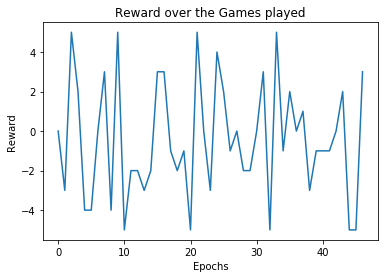

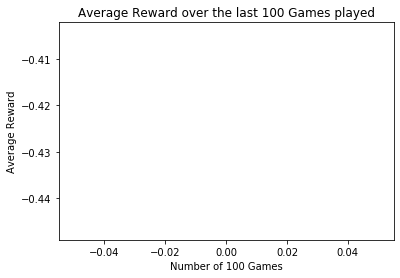

Agent 1 Win Percentage: 0.0
Agent 2 Win Percentage: 0.0
Number of Invalid Plays by Agent 1: 100
Number of Invalid Plays by Agent 2: 0


In [12]:
env = ConnectFour()

# def grid of hyperparameters
# target_model_updates = [0.01, 0.001, 0.0001]
# memory_limits = [10_000, 100_000]
# # policies = ['BoltzmannQPolicy']

# define model, define agent, train agent and adapt weights
DQN = DQN_Dense(env, target_model_update=0.01, lr=0.001, num_steps=500, policy=BoltzmannQPolicy, memory_limit=10_000,
                 window_length=1, steps_warmup=100)
model = DQN.build_conv_model()
# model = DQN.build_dense_model()
callbacks = DQN.build_callbacks()
dqn = DQN.build_agent()
history = DQN.train_agent()
model = DQN.load_weights()

# Create the game environment
env = make("connectx", debug=True)

# Two random agents play one game round
# env.run([my_agent, "random"])
env.run(['random', my_agent])

# Show the game
env.render(mode="ipython")

# evaluate performance over 100 games
get_win_percentages(my_agent, 'random')

In [13]:
# def main():
#     # define environment
#     env = ConnectFour()
    
#     # define model, define agent, train agent and adapt weights
#     DQN = DQN_Dense(env)
#     model = DQN.build_dense_model()
#     dqn = DQN.build_agent()
#     DQN.train_agent()
#     model = DQN.load_weights()
    
#     # Create the game environment
#     env = make("connectx", debug=True)

#     # Two random agents play one game round
#     env.run([my_agent, "my_agent"])

#     # Show the game
#     env.render(mode="ipython")
    
#     # evaluate performance over 100 games
#     get_win_percentages(my_agent, 'random')

In [14]:
# if __name__ == "__main__":
#     main()